In [1]:
! pip install nibabel
! pip install nilearn
! pip install -q nilearn

In [2]:
import nibabel as nib
import pandas as pd
import os
import numpy as np

In [3]:
run='1'

behav_data_path = f'/Users/graceliu/Desktop/ColumbiaThesis/data/trial_by_trial_WSW.csv'
behav_df = pd.read_csv(behav_data_path)
behav_df.head()



,subj_id,statement,face,selected_face,rt,correct,cat_chosen,cat_correct,within_error,between_error
0,1,The more he talked - the more it became eviden...,CFD-WM-020-001-N.jpg,CFD-BM-032-024-N.jpg,NaN,0,B,W,0,1
1,1,I don't know. He did seem a bit worked up. I w...,CFD-BM-004-002-N.jpg,CFD-WM-238-020-N.jpg,NaN,0,W,B,0,1
2,1,I tried hard not to engage too much - but he k...,CFD-BM-043-071-N.jpg,CFD-WM-238-020-N.jpg,NaN,0,W,B,0,1
3,1,I wanted to just walk away. It wasn't worth wa...,CFD-WM-225-127-N.jpg,CFD-WM-225-127-N.jpg,NaN,1,W,W,0,0
4,1,Yeah they were supposed to be there. Their car...,CFD-WM-225-127-N.jpg,CFD-BM-043-071-N.jpg,NaN,0,B,W,0,1


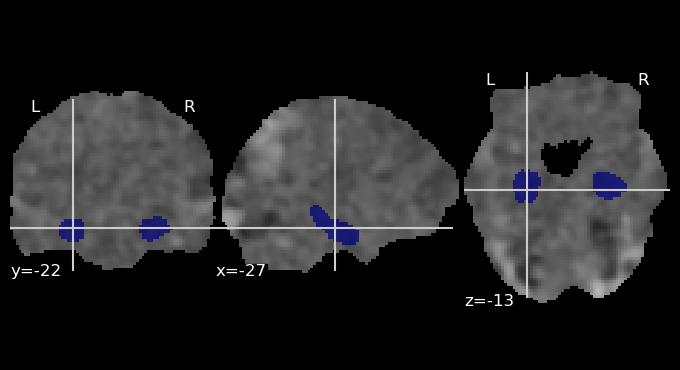

In [4]:
from nilearn.image import resample_to_img
from nilearn.plotting import plot_roi, show

#subject 001 zmap (reference image)
run1 = "/Users/graceliu/Desktop/ColumbiaThesis/zmaps/sub-001_encoding_correct_within_bt2_between_error_zmap.nii.gz"
img = nib.load(run1)

#hippocampus mask (source image)
hipp_file_path = "/Users/graceliu/Desktop/ColumbiaThesis/brain_masks/hippocampus_association-test_z_FDR_0.01.nii.gz"
hipp_img = nib.load(hipp_file_path)

#resample hippocampus mask to match Z-map
resampled_hipp_mask = resample_to_img(hipp_img, img, interpolation='continuous')

#convert resampled mask to numpy array
resampled_mask_data = resampled_hipp_mask.get_fdata()

#apply threshold to only focus on hippocampus ROI
binary_mask = (resampled_mask_data > 12).astype(np.uint8)

#save resampled mask as a new NIfTI file
mask_img = nib.Nifti1Image(binary_mask, resampled_hipp_mask.affine, resampled_hipp_mask.header)

hipp_save_path = "/Users/graceliu/Desktop/ColumbiaThesis/brain_masks/hippocampus_resampled.nii.gz"
nib.save(mask_img, hipp_save_path)

plot_roi(mask_img, bg_img = img)
show()

In [5]:
## updated hippocampus mask
# file_path = "/Users/graceliu/Desktop/ColumbiaThesis/brain_masks/hippocampus_association-test_z_FDR_0.01.nii.gz"

# # Load the NIfTI file
# img = nib.load(file_path)
# data = img.get_fdata()

# # Apply threshold to create a binary mask (1 if value > 9, else 0)
# binary_mask = (data > 9).astype(np.uint8)

# # Save the binary mask as a new NIfTI file
# mask_img = nib.Nifti1Image(binary_mask, img.affine, img.header)



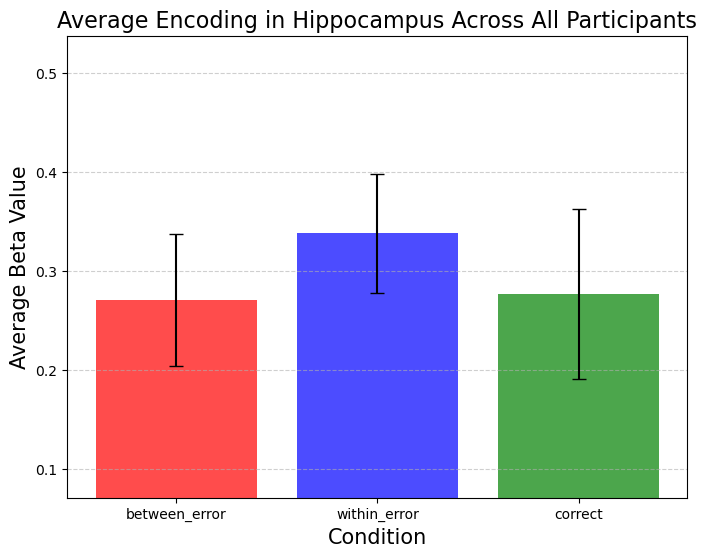

In [6]:
import matplotlib.pyplot as plt

# Define subjects (001 to 032)
subjects = [f"{i:03d}" for i in range(1, 33) if i!= 11]

# Define conditions
conditions = ["between_error", "within_error", "correct"]  # These must match your actual Z-map filenames

# Dictionary to store beta values for each condition
beta_values = {cond: [] for cond in conditions}

# Base directory where Z-maps are stored (Modify this to your actual Z-map location)
zmap_dir = "/Users/graceliu/Desktop/ColumbiaThesis/zmaps"  # Ensure this points to the right folder

# Iterate over subjects
for sub in subjects:
    for cond in conditions:
        # Construct Z-map filename (Ensure your filenames match this pattern)
        zmap_path = os.path.join(zmap_dir, f"sub-{sub}_encoding_correct_within_bt2_{cond}_zmap.nii.gz")

        if os.path.exists(zmap_path):
            # Load the Z-map
            zmap = nib.load(zmap_path)

            hippocampus_mask = np.where(mask_img.get_fdata() == 1, 1, 0).astype(np.uint8)

            # Compute mean beta value within hippocampus ROI
            zmap_data = zmap.get_fdata()
            beta_mean = np.nanmean(zmap_data[hippocampus_mask == 1])

            # Store the beta value for this subject and condition
            beta_values[cond].append(beta_mean)
        else:
            print(f"Warning: Missing file {zmap_path}")
    #break
# Compute the average & standard error of beta values across subjects
avg_beta_values = [np.mean(beta_values[cond]) for cond in conditions]
sem_beta_values = [np.std(beta_values[cond], ddof=1) / np.sqrt(len(beta_values[cond])) for cond in conditions]  

# Fix y-axis scale: Set limits based on data range
y_min = min(avg_beta_values) - 0.2  # Small buffer below min
y_max = max(avg_beta_values) + 0.2  # Small buffer above max

plt.figure(figsize=(8, 6))
plt.bar(conditions, avg_beta_values, yerr=sem_beta_values, color=['red', 'blue', 'green'], alpha=0.7, capsize=5)
plt.xlabel("Condition", fontsize=15)
plt.ylabel("Average Beta Value", fontsize=15)
plt.title("Average Encoding in Hippocampus Across All Participants", fontsize=16)
plt.ylim(y_min, y_max) 
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

In [7]:
print(len(beta_values['correct']))

31


In [8]:
import scipy.stats as stats
# ANOVA to compare means across conditions
anova_WSW = stats.f_oneway(beta_values["between_error"], beta_values["within_error"], beta_values["correct"])

# Display ANOVA results
anova_WSW_df = pd.DataFrame({"ANOVA F-statistic": [anova_WSW.statistic], "ANOVA p-value": [anova_WSW.pvalue]})
print(anova_WSW_df)


   ANOVA F-statistic  ANOVA p-value
0            0.26854       0.765105


no signficant difference in hippocampus activity between the three conditions

In [9]:
# t-tests
t_results = {}
comparisons = [("between_error", "within_error"), ("between_error", "correct"), ("within_error", "correct")]

for cond1, cond2 in comparisons:
    t_stat, p_value = stats.ttest_ind(beta_values[cond1], beta_values[cond2], equal_var=False)
    t_results[f"{cond1} vs. {cond2}"] = (t_stat, p_value)

# Print t-test results
print("\nPairwise t-tests:")
for comparison, (t_stat, p_val) in t_results.items():
    print(f"{comparison}: t = {t_stat:.3f}, p = {p_val:.5f}")



Pairwise t-tests:
between_error vs. within_error: t = -0.750, p = 0.45651
between_error vs. correct: t = -0.053, p = 0.95814
within_error vs. correct: t = 0.584, p = 0.56167


no significant difference between the three conditions. they all have almost no or very little difference. t-value close to 0 means almost no difference

In [10]:
#effect sizes
grand_mean = np.mean([val for cond in beta_values.values() for val in cond])
ss_between = sum(len(beta_values[cond]) * (np.mean(beta_values[cond]) - grand_mean) ** 2 for cond in conditions)
ss_total = sum((val - grand_mean) ** 2 for cond in beta_values.values() for val in cond)

eta_squared = ss_between / ss_total

print(f"Effect Size (Eta Squared): {eta_squared:.4f}")

Effect Size (Eta Squared): 0.0059


0.66% of variance in beta values is due to differences in condition, so conditions explain almost none of the variance.

In [11]:
def cohens_d(group1, group2):
    diff = np.mean(group1) - np.mean(group2)
    pooled_std = np.sqrt((np.std(group1, ddof=1) ** 2 + np.std(group2, ddof=1) ** 2) / 2)
    return diff / pooled_std

# Compute Cohen’s d for pairwise comparisons
effect_size_between_within = cohens_d(beta_values["between_error"], beta_values["within_error"])
effect_size_between_correct = cohens_d(beta_values["between_error"], beta_values["correct"])
effect_size_within_correct = cohens_d(beta_values["within_error"], beta_values["correct"])

print(f"Cohen's d (Between vs Within): {effect_size_between_within:.4f}")
print(f"Cohen's d (Between vs Correct): {effect_size_between_correct:.4f}")
print(f"Cohen's d (Within vs Correct): {effect_size_within_correct:.4f}")

Cohen's d (Between vs Within): -0.1904
Cohen's d (Between vs Correct): -0.0134
Cohen's d (Within vs Correct): 0.1483


between vs. within: small decrease in hippocampal activation in between condition compared to within condition

between vs. correct: small decrease in hippocampal activation in between condition compared to correct condition, but basically nonexistent 

withini vs. correct: small increase in hippocampal activation in within condition compared to correct condition 